In [6]:
import torch
import matplotlib.colors as mcolors
from data_prep.preprocess import *
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch.utils.data import DataLoader, random_split
from torch import Tensor
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from PIL import Image
from io import BytesIO
import numpy as np
import os

In [7]:
""" Parts of the U-Net model """


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        logits = F.softmax(x, dim=1)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [9]:
model3 = UNet(n_channels=3, n_classes=3)
mps_device = torch.device("cpu")
weights_file = 'C:\\Users\\mjaic\\OneDrive\\Desktop\\Delft\\Year 1\\Q4\\Seminar-Computer-Vision-by-Deep-Learning\\3class_3k_10epochs.pth'
model3.load_state_dict(torch.load(weights_file, map_location=torch.device('cpu')))
model3 = model3.to(mps_device)

model18 = UNet(n_channels=3, n_classes=18)
mps_device = torch.device("cpu")
weights_file = 'C:\\Users\\mjaic\\OneDrive\\Desktop\\Delft\\Year 1\\Q4\\Seminar-Computer-Vision-by-Deep-Learning\\18classModel.pth'
model18.load_state_dict(torch.load(weights_file, map_location=torch.device('cpu')))
model18 = model18.to(mps_device)

In [10]:
dataset = pq.ParquetDataset('C:\\Users\\mjaic\\OneDrive\\Desktop\\Delft\\Year 1\\Q4\\Seminar-Computer-Vision-by-Deep-Learning\\data')

table = dataset.read()
df = table.to_pandas()
idx = 14165
image = Image.open(BytesIO(df.iloc[idx, 0]['bytes'])) # image
mask = np.array(Image.open(BytesIO(df.iloc[idx, 1]['bytes']))).astype(np.float16) # mask
#image.show()

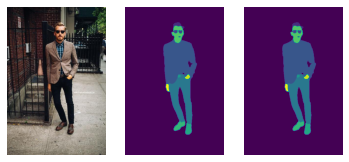

In [11]:

def show_images(base, class3, class18, save = "", display = True):
    fig, ax = plt.subplots(1, 3)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')

    
    ax[0].imshow(base)
    ax[1].imshow(class3)
    ax[2].imshow(class18)

    if save:
        plt.savefig(save, bbox_inches='tight', pad_inches=0)

    if display:
        plt.show()

def generate_image(image, save = "", display = True):
    plt.imshow(image)
    plt.axis("off")

    if save:
        plt.savefig(save, bbox_inches='tight', pad_inches=0)

    if display:
        plt.show()

def generate_colormapped_image(segmentation_output, path = "", num_classes = 18, display = True):
    assert num_classes < 20
    colormap = plt.get_cmap('tab20', num_classes)  # 'tab20' has 20 distinct colors

    # Normalize the segmentation output to the range [0, 1] for mapping to colormap
    norm = mcolors.Normalize(vmin=0, vmax=num_classes - 1)

    # Create an RGB image from the segmentation map
    _, segmentation_output = torch.max(segmentation_output, dim = 2)
    
    segmentation_rgb = colormap(norm(segmentation_output))
    
    #Plot the segmentation result
    plt.imshow(segmentation_rgb[:, :, :3])
    plt.axis('off')  # Remove the axes

    # Save the plot as an image file
    if path:
        plt.savefig(path, bbox_inches='tight', pad_inches=0)
    
    if display:
        # Display the plot (optional)
        plt.show()
    
    return segmentation_rgb[:, :, :3]
    
show_images(image, mask, mask)

In [12]:
train_loader, test_loader = Preprocess().get_data_loaders(mask_classes=3, use_simple_mask=False, batch_size=1, subset_size=1)

tensor([0.9651, 1.0227, 1.0452])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


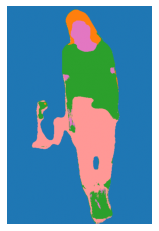

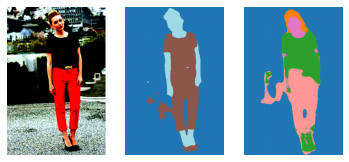

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.5843, 1.7372, 0.4895])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


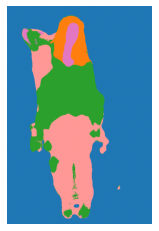

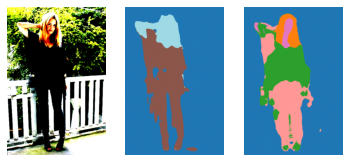

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.6478, 1.7530, 1.8866])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


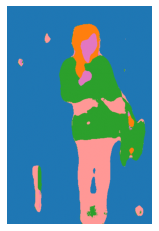

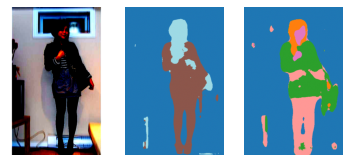

In [15]:
num_pictures = 100
path = ".\\images"
i = 0
for inputs, labels in test_loader:
    curr_dir = os.path.join(path, str(i))

    try:
        os.makedirs(curr_dir)
    except OSError:
        pass
    
    inputs, labels = inputs.to(mps_device), labels.to(mps_device)
    outputs3 = model3(inputs)
    outputs18 = model18(inputs)

    inputs = inputs.detach()
    outputs3 = outputs3.detach()
    outputs18 = outputs18.detach()
    
    img_input = inputs[0].permute(1, 2, 0)
    img_3_class = outputs3[0].permute(1, 2, 0)
    img_18_class = outputs18[0].permute(1, 2, 0)

    generate_image(img_input, os.path.join(curr_dir, "base"), display = False)
    processed_3 = generate_colormapped_image(img_3_class, os.path.join(curr_dir, "3_class_model"), num_classes=3, display = False)
    processed_18 = generate_colormapped_image(img_18_class, os.path.join(curr_dir, "18_class_model"), num_classes=18, display = False)
    show_images(img_input, processed_3, processed_18, os.path.join(curr_dir, "combined"))

    i+= 1
    if i >= num_pictures:
        break